In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew

In [57]:
# --- 1. MOUNTING & PATH CONFIGURATION ---
def log_audit(message):
    print(f"[AUDIT LOG] {message}")

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_PATH = '/content/drive/MyDrive/Capstone/'
    log_audit("Drive mounted successfully.")
except Exception as e:
    BASE_PATH = './'
    log_audit(f"Manual mount required or local run. Error: {e}")

INPUT_PATH = os.path.join(BASE_PATH, 'integrated_data.csv')
OUTPUT_PATH = os.path.join(BASE_PATH, 'cleaned_data.csv')

Mounted at /content/drive
[AUDIT LOG] Drive mounted successfully.


In [58]:
# --- 2. DATA LOADING ---
df = pd.read_csv(INPUT_PATH)
log_audit(f"Data Loaded. Shape: {df.shape}")

[AUDIT LOG] Data Loaded. Shape: (51336, 87)


In [59]:
# ---3. Identifying -99999 as Nulls
log_audit("Replacing -99999 with NaN...")
df.replace(-99999, np.nan, inplace=True)

[AUDIT LOG] Replacing -99999 with NaN...


In [60]:
# ---4. Null Density Check
null_counts = df.isnull().sum()
log_audit(f"Top 5 Null Columns:\n{null_counts.sort_values(ascending=False).head(5)}")

[AUDIT LOG] Top 5 Null Columns:
CC_utilization                  47636
PL_utilization                  44435
time_since_recent_deliquency    35949
max_delinquency_level           35949
time_since_first_deliquency     35949
dtype: int64


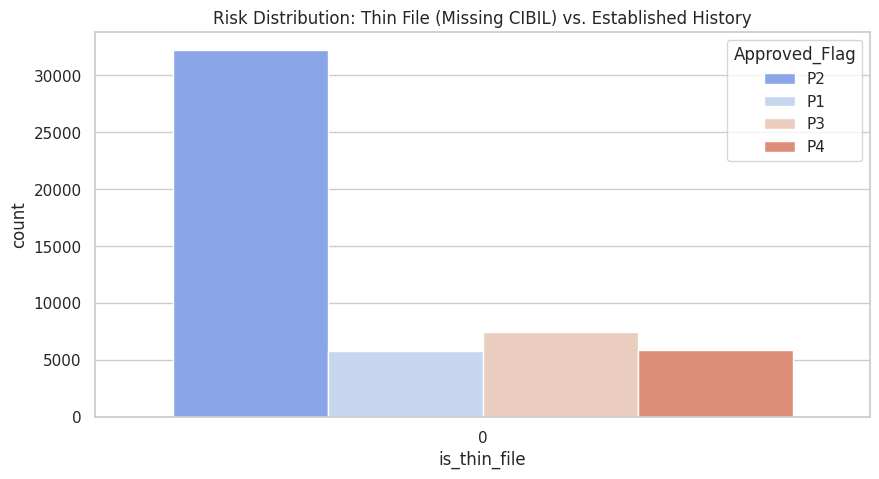

In [61]:
# ---5. Create a flag: Does the user have missing CIBIL data?
# In credit risk, a null is often a 'Thin-file' signal
df['is_thin_file'] = df['Credit_Score'].isnull().astype(int)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='is_thin_file', hue='Approved_Flag', palette='coolwarm')
plt.title('Risk Distribution: Thin File (Missing CIBIL) vs. Established History')
plt.show()

[AUDIT LOG] Analyzing Average Loan Portfolio per Risk Grade...


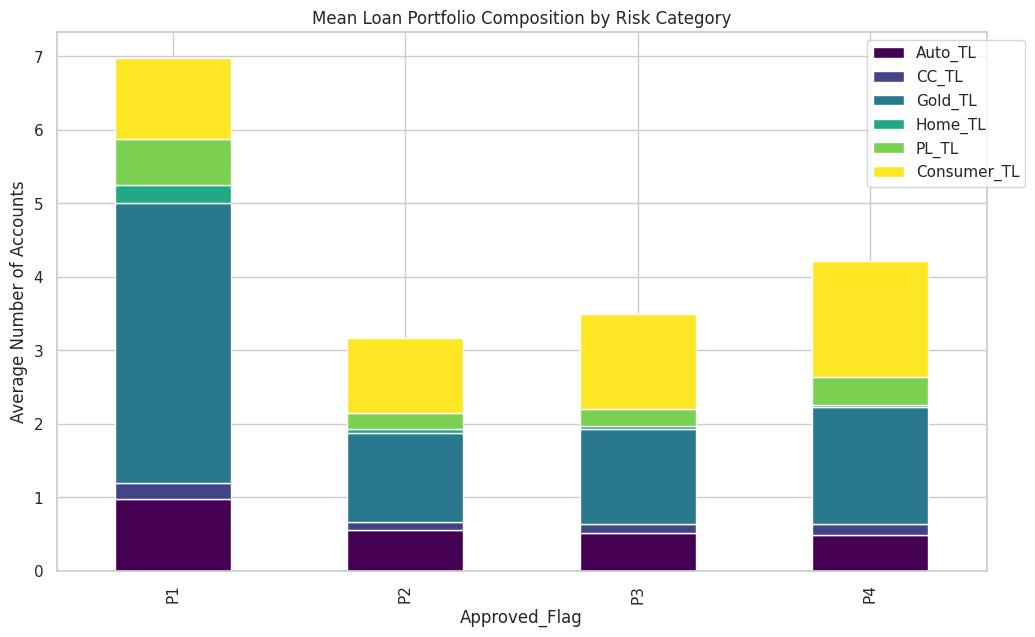

In [62]:
# --- 6. PORTFOLIO MIX ANALYSIS (INTERNAL vs EXTERNAL) ---
log_audit("Analyzing Average Loan Portfolio per Risk Grade...")

# Grouping loan types from  variable lists
loan_types = ['Auto_TL', 'CC_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Consumer_TL']
available_loans = [c for c in loan_types if c in df.columns]

portfolio_mix = df.groupby('Approved_Flag')[available_loans].mean()

portfolio_mix.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')
plt.title('Mean Loan Portfolio Composition by Risk Category')
plt.ylabel('Average Number of Accounts')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

[AUDIT LOG] Generating Segmented Risk Heatmaps...


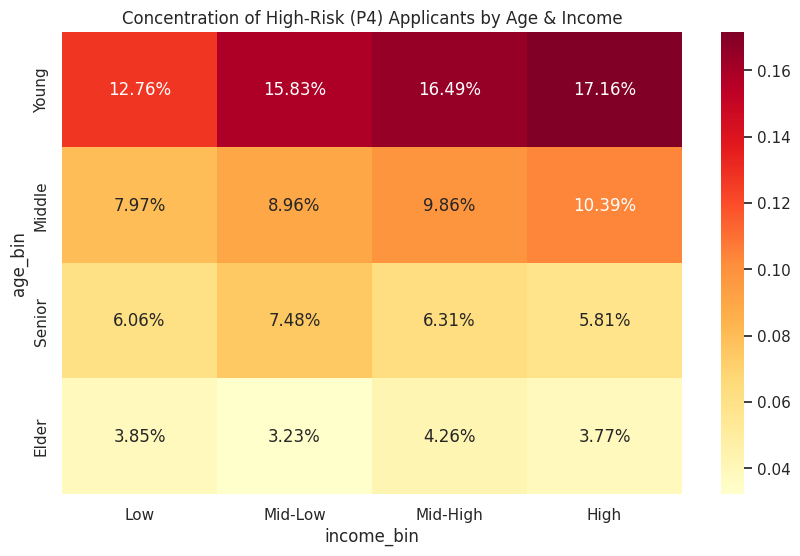

In [63]:
# --- 7. RISK SEGMENTATION: INCOME vs AGE ---
log_audit("Generating Segmented Risk Heatmaps...")

# Creating bins for Age and Income for a 'Risk Grid'
df['age_bin'] = pd.cut(df['AGE'], bins=[18, 30, 45, 60, 100], labels=['Young', 'Middle', 'Senior', 'Elder'])
df['income_bin'] = pd.qcut(df['NETMONTHLYINCOME'], 4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

# Pivot table for 'P4' (High Risk) concentration
risk_grid = pd.crosstab(df['age_bin'], df['income_bin'],
                        values=(df['Approved_Flag'] == 'P4').astype(int),
                        aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(risk_grid, annot=True, cmap='YlOrRd', fmt='.2%')
plt.title('Concentration of High-Risk (P4) Applicants by Age & Income')
plt.show()

[AUDIT LOG] Visualizing Demographic Distribution for Bias Detection...


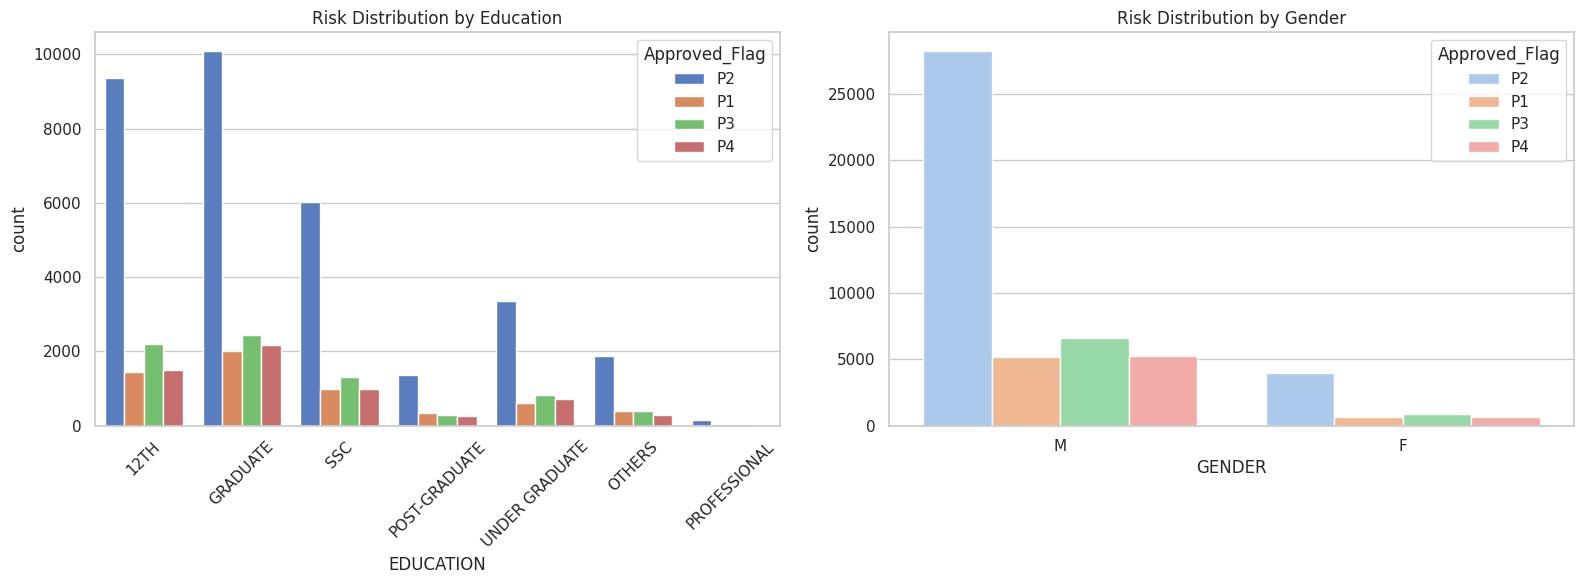

In [64]:
# --- 8. BIAS & ETHICS PRE-CHECK ---
log_audit("Visualizing Demographic Distribution for Bias Detection...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Education Risk Profile
sns.countplot(ax=axes[0], data=df, x='EDUCATION', hue='Approved_Flag', palette='muted')
axes[0].set_title('Risk Distribution by Education')
axes[0].tick_params(axis='x', rotation=45)

# Gender Risk Profile
sns.countplot(ax=axes[1], data=df, x='GENDER', hue='Approved_Flag', palette='pastel')
axes[1].set_title('Risk Distribution by Gender')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3254551717.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Approved_Flag', palette='viridis')


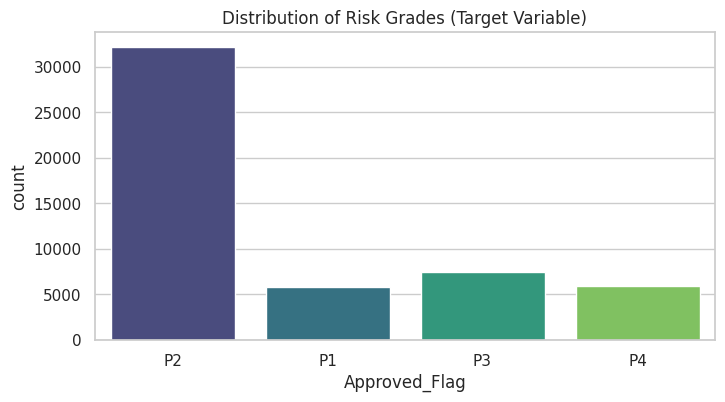

In [65]:
# 9. Target Balance Check
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Approved_Flag', palette='viridis')
plt.title('Distribution of Risk Grades (Target Variable)')
plt.show()

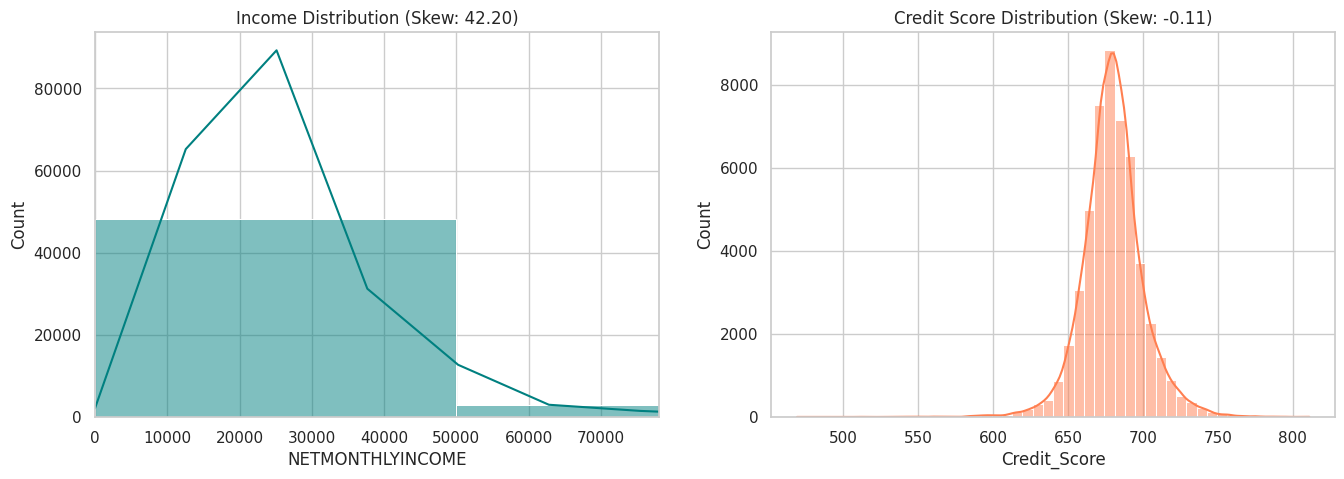

In [66]:
# ---10. Financial Distributions (Income & Score)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df['NETMONTHLYINCOME'].dropna(), bins=50, kde=True, ax=ax1, color='teal')
ax1.set_title(f"Income Distribution (Skew: {df['NETMONTHLYINCOME'].skew():.2f})")
ax1.set_xlim(0, df['NETMONTHLYINCOME'].quantile(0.99)) # Truncate for visibility

sns.histplot(df['Credit_Score'].dropna(), bins=50, kde=True, ax=ax2, color='coral')
ax2.set_title(f"Credit Score Distribution (Skew: {df['Credit_Score'].skew():.2f})")
plt.show()

<Figure size 1200x600 with 0 Axes>

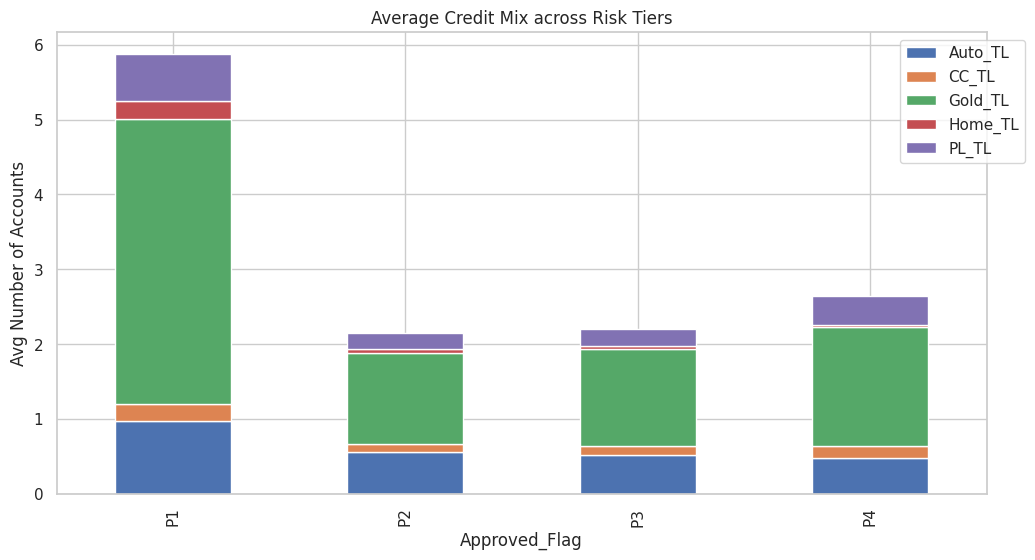

In [67]:
# ---11. Loan Portfolio Mix (Internal vs. External)
loan_cols = ['Auto_TL', 'CC_TL', 'Gold_TL', 'Home_TL', 'PL_TL']
available = [c for c in loan_cols if c in df.columns]

plt.figure(figsize=(12, 6))
df.groupby('Approved_Flag')[available].mean().plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Average Credit Mix across Risk Tiers')
plt.ylabel('Avg Number of Accounts')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [68]:
# ---12. Missingness as a Signal (Thin File Analysis)
df['is_thin_file'] = df['Credit_Score'].isnull().astype(int)
ct = pd.crosstab(df['is_thin_file'], df['Approved_Flag'], normalize='index')
log_audit(f"Risk Concentration for Thin Files:\n{ct}")

[AUDIT LOG] Risk Concentration for Thin Files:
Approved_Flag       P1        P2        P3        P4
is_thin_file                                        
0              0.11304  0.627221  0.145161  0.114578


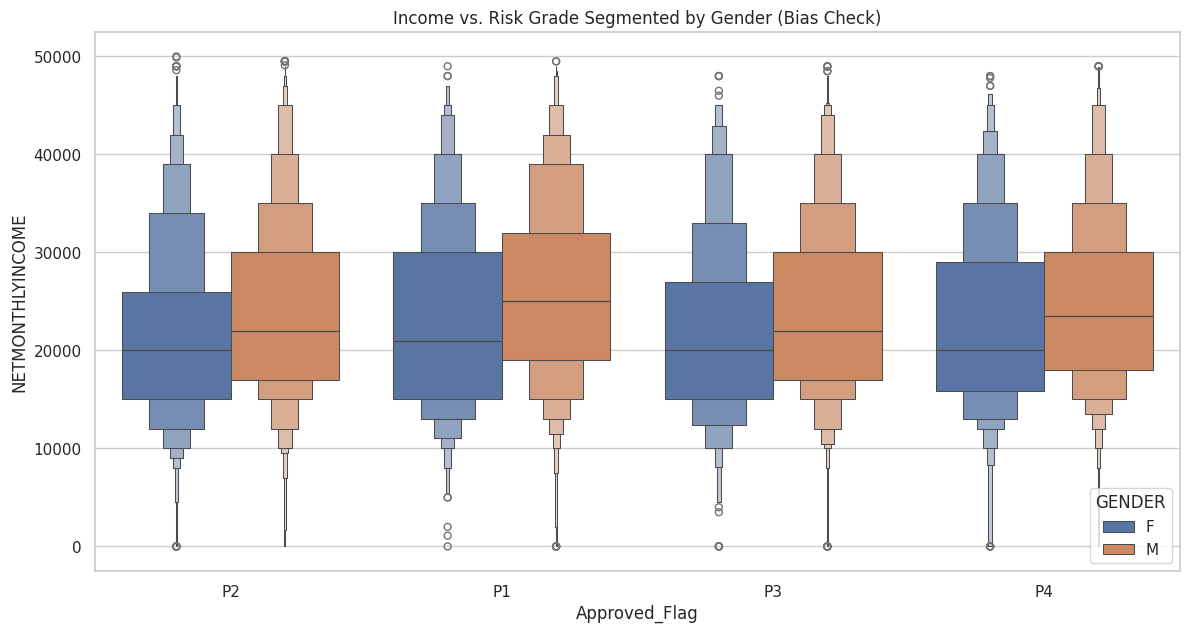

In [69]:
# ---13. Segmented Risk: Age vs. Income vs. Risk Grade
plt.figure(figsize=(14, 7))
# Visualize how high-income younger vs older people fall into risk categories
sns.boxenplot(data=df[df['NETMONTHLYINCOME'] < df['NETMONTHLYINCOME'].quantile(0.95)],
              x='Approved_Flag', y='NETMONTHLYINCOME', hue='GENDER')
plt.title('Income vs. Risk Grade Segmented by Gender (Bias Check)')
plt.show()

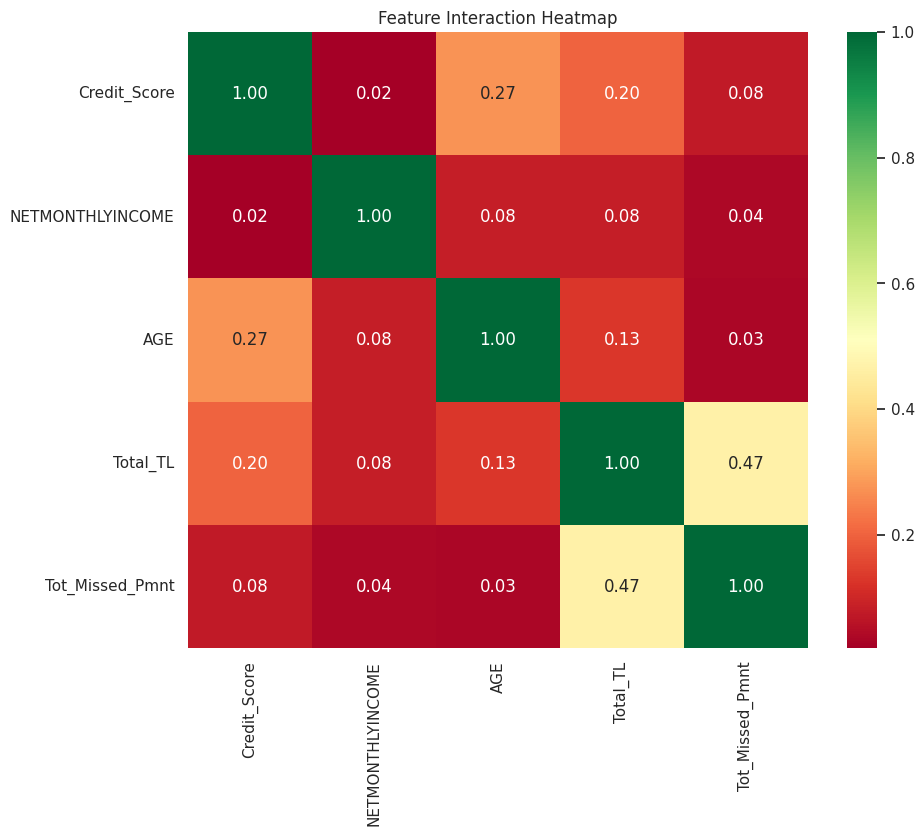

In [70]:
# ---14. Correlation Heatmap (Select Features)
top_features = ['Credit_Score', 'NETMONTHLYINCOME', 'AGE', 'Total_TL', 'Tot_Missed_Pmnt']
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features].corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Feature Interaction Heatmap')
plt.show()

In [71]:
#--- 15. EXPORT ---
df.to_csv(OUTPUT_PATH, index=False)
log_audit(f"Full EDA Process Complete. Cleaned data saved to {OUTPUT_PATH}.")

[AUDIT LOG] Full EDA Process Complete. Cleaned data saved to /content/drive/MyDrive/Capstone/cleaned_data.csv.
